# Description

This script will run the Sparse Box-Constrained Non-Negative Matrix Factorization on the 11 self-report questions (excluding wakefulness). This is the version that separately applies sparsity to the Q and W matrices and that also accounts for potential demographics condounds.

Before running this notebook, you need to run Notebook S11 to decide on the best hyper-paramteres (e.g., dimensionality and sparsity values)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
import os.path as osp
import holoviews as hv
from holoviews import opts
from scipy.stats import ttest_ind, mannwhitneyu, ttest_rel, wilcoxon
import panel as pn
from wordcloud import WordCloud
import hvplot.pandas
from IPython.display import Markdown as md
from IPython import display
from PIL import Image
import matplotlib.pyplot as plt
from textwrap import wrap
import bokeh

In [3]:
print(pd.__version__)
print(hvplot.__version__)
print(bokeh.__version__)

1.5.3
0.8.4
3.2.1


In [4]:
from matplotlib import rc
font_dict = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}
rc('font', **font_dict)

In [5]:
from dataclasses import dataclass

In [6]:
@dataclass
class matrix_class:

    M : np.ndarray # (column)-normalized data matrix
    M_raw : np.ndarray # raw data matrix
    confound : np.ndarray # normalized confounder matrix
    confound_raw : np.ndarray # raw confounder matrix
    nan_mask : np.ndarray # mask matrix for missing entires (0=missing, 1=available)
    row_idx : np.ndarray # global row index (for multiple data matrices)
    col_idx : np.ndarray # global column index (for multiple data matrices)
    mask : np.ndarray # global mask (for multiple data matrices)
    dataname : str # dataname
    subjlist : list # information on subjects (row information)
    itemlist : list # information on items (column information)
    W : np.ndarray # subject embedding (recall M = [W, C]Q^T)
    Q : np.ndarray # item embedding (recall M = [W, C]Q^T)
    C : np.ndarray # confounder matrix
    Qc : np.ndarray # confounders' loadings (recall Q = [RQ, CQ])
    Z : np.ndarray # auxiliary Z=WQ^T (ADMM)
    aZ : np.ndarray # auxiliary variables (ADMM)

In [7]:
import sys
sys.path.append('./mlt/')
from method.ICQF.ICQF import ICQF

In [8]:
from utils.basics import get_sbj_scan_list, SNYCQ_Questions, SNYCQ_Question_type, SNYCQ_CLUSTERS_INFO_PATH, DATA_DIR, PRJ_DIR, SNYCQ_W_PATH, SNYCQ_Q_PATH
from utils.SNYCQ_NMF_Extra import plot_Q_bars, cluster_scans, plot_W, plot_W_scatter, plot_P,plot_W_heatmap

# 1. Load list of Scans, Subjects and the SNYCQ dataframe

Get list of scans, subjects and the SNYCQ dataframe for the data entering the analyses

In [9]:
SBJs, SCANs, SNYCQ = get_sbj_scan_list(when='post_motion', return_snycq=True)

++ [post_motion] Number of subjects: 133 subjects
++ [post_motion] Number of scans:    471 scans


Remove the Vigilance/Wakefulness Question from the dataframe

In [10]:
SNYCQ = SNYCQ.drop('Vigilance',axis=1)
Nscans, Nquestions = SNYCQ.shape
print(SNYCQ.shape)

(471, 11)


# 2. Apply Sparse Box-Constrained Non-Negative Factorization to the SNYCQ dataframe

The line below will run the algorithm with the following hyper-parameters:

* Attempt Demographic Confound Modeling is `True`
* W bounded to range `[0,1]`
* Q bounded to range `[0,100]`
* W sparsity is `0.0`
* Q sparsity is `0.01`
* Number of maximum iterations is `200`
* Dimensionality is `2`

In [11]:
data  = np.load('./mlt/output/full_data.npz')
M_arr = data['M']
nan_mask = data['nan_mask']
confound = data['confound']
MF_data = matrix_class(M_arr, None, confound, None, nan_mask, None, None,
                       None, None, None, None, None, None,
                       None, None, None, None)
DIM=2
clf = ICQF(DIM, rho=3, tau=3, regularizer=1,
                        W_upperbd=(True, 1.0),
                        Q_upperbd=(True, 100),
                        M_upperbd=(True, 100),
                        W_beta=0.0,
                        Q_beta=0.01,
                        max_iter=200)
MF_data, loss_list = clf.fit_transform(MF_data)

Sanity check to ensure that the inputs used in the hyper-parameter exploration and here on the final application of the algorithm are the same

In [12]:
M = SNYCQ.values.astype('float')
print('Range of data matrix M:      [min={}, max={}]'.format(np.min(M), np.max(M)))
print('Dimensions of data matrix M: [#scans={}, #questions={}]'.format(M.shape[0],M.shape[1]))
assert np.sum(np.isnan(M)) == 0 # Make sure there are no missing values
assert np.all(M_arr==M), "Input to algorithm based on data given to MLT and mine are NOT the same"

Range of data matrix M:      [min=0.0, max=100.0]
Dimensions of data matrix M: [#scans=471, #questions=11]


In [19]:
pd.DataFrame(M.T).hvplot.heatmap()

:HeatMap   [columns,index]   (value)

# 2.1. Convert outputs to DataFrames with meaningful indexing for plotting

In [20]:
W = pd.DataFrame(MF_data.W, index=SNYCQ.index, columns=['Factor {d}'.format(d=d+1) for d in range(DIM)])
Q = pd.DataFrame(MF_data.Q, index=SNYCQ.columns, columns=['Factor {d}'.format(d=d+1) for d in range(DIM)])
C = pd.DataFrame(MF_data.C, index=SNYCQ.index, columns=['Age (elder)','Gender (M)','Age (younger)','Gender (F)','Intercept'])
C = C[['Intercept','Age (younger)','Age (elder)','Gender (M)','Gender (F)']] # Sorting to make it more interpretable
Qc = pd.DataFrame(MF_data.Qc, index=SNYCQ.columns, columns = ['Age (elder)','Gender (M)','Age (younger)','Gender (F)','Intercept'])
Qc = Qc[['Intercept','Age (younger)','Age (elder)','Gender (M)','Gender (F)']] # Sorting to make it more interpretable

# 3. Plot the different outputs from the algorithm

First, we will plot the W matrix (low dimensional represenation of interest) and the Qc matrix (encoding of the demographic data)

In [21]:
W_plot_unsroted = W.reset_index(drop=True).hvplot.heatmap(cmap='Greens', width=200, height=500, fontscale=1.2, clim=(0,1), shared_axes=False).opts( colorbar_opts={'title':'W Matrix'}, xrotation=90, toolbar=None)
C_plot_unsorted = C.reset_index(drop=True).hvplot.heatmap(cmap='Purples', width=250, height=500, fontscale=1.2).opts( colorbar_opts={'title':'C Matrix'}, xrotation=90, toolbar=None)
f = pn.Row(W_plot_unsroted,C_plot_unsorted)
f#.save('./figures/S12_W_and_C_unsorted.png')

Row
    [0] HoloViews(HeatMap, height=500, sizing_mode='fixed', width=200)
    [1] HoloViews(HeatMap, height=500, sizing_mode='fixed', width=250)

Show static version (for Github purposes)

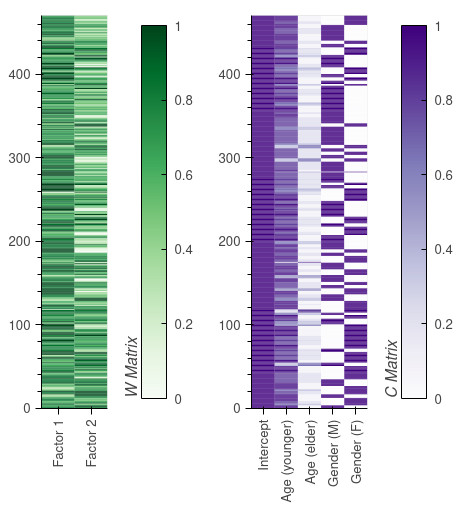

In [22]:
display.Image("./figures/S12_W_and_C_unsorted.png")

Next, we will plot the Q matrix (with relationships between questions and low dimensional factors) and the Qc matrix (with information about how responses relate to demographics)

In [23]:
Q_plot_unsorted  = Q.hvplot.heatmap( cmap='Oranges', width=240, height=500, clim=(0,100), fontscale=1.2, shared_axes=False).opts( colorbar_opts={'title':'Q Matrix'}, xrotation=90, toolbar=None)
Qc_plot_unsorted = Qc.hvplot.heatmap(cmap='Reds', width=300, height=500, clim=(0,100), fontscale=1.2).opts( colorbar_opts={'title':'Qc Matrix'}, xrotation=90, toolbar=None)
f = pn.Row(Q_plot_unsorted, Qc_plot_unsorted)
f#.save('./figures/S12_Q_and_Qc_unsorted_same_scale.png')

Row
    [0] HoloViews(HeatMap, height=500, sizing_mode='fixed', width=240)
    [1] HoloViews(HeatMap, height=500, sizing_mode='fixed', width=300)

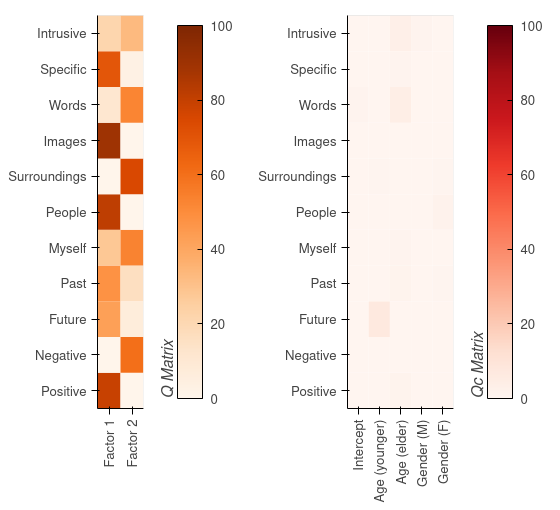

In [24]:
display.Image("./figures/S12_Q_and_Qc_unsorted_same_scale.png")

We also plot Q and Qc after sorting. This helps better understand what the different factors mean in relationship to the original questions

In [28]:
sorted_q = Q.sort_values(by=['Factor 1'],ascending=False).index
Q_plot_sorted  = Q.loc[sorted_q].hvplot.heatmap( cmap='Oranges', width=240, height=500, clim=(0,100), fontscale=1.2, shared_axes=False).opts( colorbar_opts={'title':'Thought Patterns'}, xrotation=90, toolbar=None)
Qc_plot_sorted = Qc.loc[sorted_q].hvplot.heatmap(cmap='Reds', width=300, height=500, clim=(0,100), fontscale=1.2).opts( colorbar_opts={'title':'Qc Matrix'}, xrotation=90, toolbar=None)
f = pn.Row(Q_plot_sorted, Qc_plot_sorted)
f#.save('./figures/S12_Q_and_Qc_sorted_diff_scale.png')

Row
    [0] HoloViews(HeatMap, height=500, sizing_mode='fixed', width=240)
    [1] HoloViews(HeatMap, height=500, sizing_mode='fixed', width=300)

In [32]:
Q_aux = Q.copy()
Q_aux.columns = ['TP1','TP2']
sorted_q_aux = Q_aux.sort_values(by=['TP1'],ascending=False).index
Q_aux_plot_sorted  = Q_aux.loc[sorted_q_aux].hvplot.heatmap( cmap='Oranges', width=240, height=500, clim=(0,100), fontscale=1.2, shared_axes=False).opts( colorbar_opts={'title':'Thought Patterns'}, xrotation=90, toolbar=None)
Q_aux_plot_sorted
#sorted_q = Q.sort_values(by=['Factor 1'],ascending=False).index
#Q_plot_sorted  = Q.loc[sorted_q].hvplot.heatmap( cmap='Oranges', width=240, height=500, clim=(0,100), fontscale=1.2, shared_axes=False).opts( colorbar_opts={'title':'Thought Patterns'}, xrotation=90, toolbar=None)


:HeatMap   [columns,index]   (value)

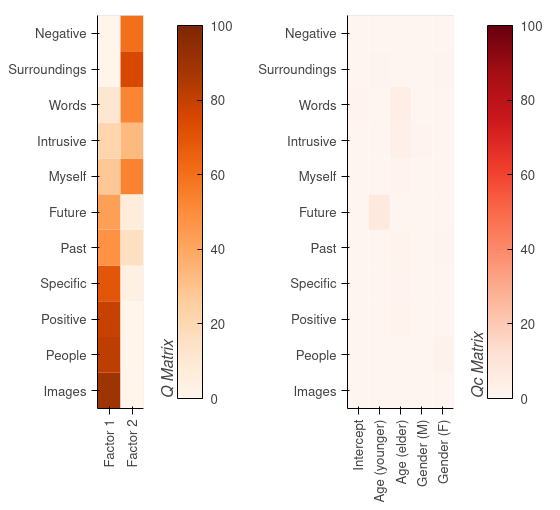

In [19]:
display.Image("./figures/S12_Q_and_Qc_sorted_diff_scale.png")

We will also plot each Q column separately, this will help us convey the meaning of Factor 1 and Factor 2 in the scatter plot

In [20]:
f = Q.sort_values(by='Factor 1', ascending=False)['Factor 1'].hvplot.heatmap(cmap='Gray', 
                                                                         clim=(0,100), width=110, 
                                                                         colorbar=False, xaxis=None).opts(toolbar=None, line_color='k', line_width=1)
pn.Row(f) #.save('./figures/S12_Q_Factor1_sorted.png')

Row
    [0] HoloViews(HeatMap, height=300, sizing_mode='fixed', width=110)

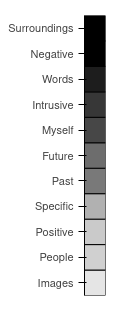

In [21]:
display.Image('./figures/S12_Q_Factor1_sorted.png')

In [22]:
f = Q.sort_values(by='Factor 2', ascending=True)['Factor 2'].hvplot.heatmap(cmap='Gray', 
                                                                         clim=(0,100), width=110, 
                                                                         colorbar=False, xaxis=None).opts(toolbar=None, line_color='k', line_width=1)
pn.Row(f) #.save('./figures/S12_Q_Factor2_sorted.png')

Row
    [0] HoloViews(HeatMap, height=300, sizing_mode='fixed', width=110)

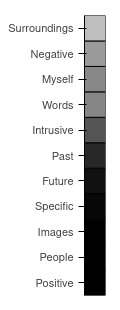

In [23]:
display.Image('./figures/S12_Q_Factor2_sorted.png')

In [24]:
Q.sort_values(by='Factor 2', ascending=True)['Factor 2'].hvplot.heatmap(cmap='Oranges', 
                                                                         clim=(0,100), width=160, 
                                                                         colorbar=True, xaxis=None).opts(toolbar=None, line_color='k', line_width=1)

:HeatMap   [columns,index]   (value)

In [25]:
W.to_csv(SNYCQ_W_PATH)
print('++ INFO: Saving W matrix to: %s' % SNYCQ_W_PATH)

Q.to_csv(SNYCQ_Q_PATH)
print('++ INFO: Saving W matrix to: %s' % SNYCQ_Q_PATH)
print(pd.__version__)

++ INFO: Saving W matrix to: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/snycq/SNYCQ_W.csv
++ INFO: Saving W matrix to: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/snycq/SNYCQ_Q.csv
1.5.3


# 4. Create Wordclouds that represent the two factors

Each factor in the low dimensional representation of W is associated with the original questions as described in matrix Q. To help carry these relationships in a graphic way across different figures, we will generate one wordcloud per factor using the infoermation in matrix Q.

1. We will create a circular mask to be used as the enclosing shape for the wordcloud

In [25]:
x, y = np.ogrid[:300, :300]
circle_mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
circle_mask = 255 * circle_mask.astype(int)

This function will help us create wordcloud where the importance of a term is represented both by the font size and the color. More important words will have darker colors.

In [26]:
def my_tf_color_func(dictionary):
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        freq_as_int = int(dictionary[word])
        color_list = sns.color_palette('dark:#5A9_r',100).as_hex()
        return color_list[freq_as_int]
    return my_tf_color_func_inner

We also load a basic mask in the form of a sagital brain to use as the confines of the wordcloud

In [27]:
brain_mask = np.array(Image.open(osp.join(PRJ_DIR,'code','fc_introspection','resources','wordclouds','Brain_Sag.png')))
brain_mask = brain_mask > 100
brain_mask = 255 * brain_mask.astype(int)

2. We generate the wordcloud for factor 1

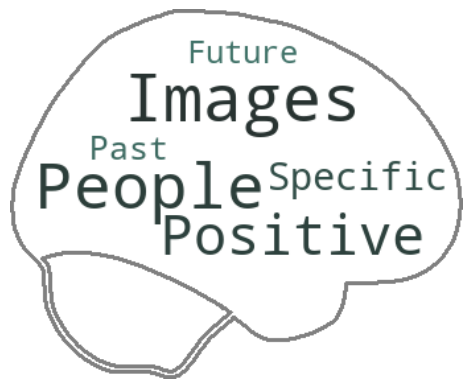

In [28]:
wc = WordCloud(max_font_size=50, min_font_size=5, 
               width=200, height=200,contour_color='gray', contour_width=3,
               max_words=6, background_color='white', 
               repeat=True,
               relative_scaling=0.5, mask=brain_mask,
               color_func=my_tf_color_func(Q['Factor 1'].to_dict())).generate_from_frequencies(Q['Factor 1'].to_dict())
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
wc.to_file('./figures/S12_Factor1_WC.png')

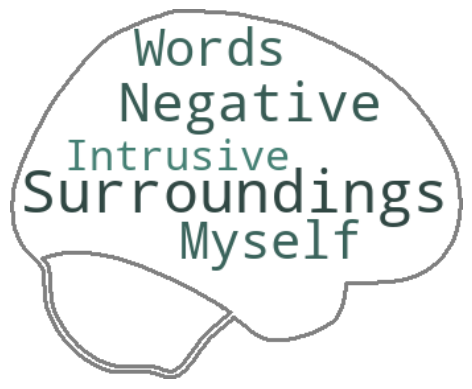

In [29]:
wc = WordCloud(max_font_size=50, min_font_size=5, 
               width=200, height=200,contour_color='gray', contour_width=3, colormap='bone',
               max_words=5, background_color='white', mask=brain_mask,
               repeat=True, 
               relative_scaling=0.5,
               color_func=my_tf_color_func(Q['Factor 2'].to_dict())).generate_from_frequencies(Q['Factor 2'].to_dict())
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
wc.to_file('./figures/S12_Factor2_WC.png')

# 5. Show Original and Reconstructed Matrix

For this, we first recompute the reconstructed matrix by applying the formulation inherent to Sparse Non-Negative Matrix Factorization

$$M_{recon} = [ W, C] \cdot [Q, Q_{c}]^`$$

In [30]:
Mrecon = pd.DataFrame(np.dot(pd.concat([W,C],axis=1).values, pd.concat([Q,Qc],axis=1).values.T),
                      index=SNYCQ.index,columns=SNYCQ.columns)

In [31]:
Morig = pd.DataFrame(M,index=SNYCQ.index,columns=SNYCQ.columns)

In [32]:
f = (Morig.reset_index(drop=True).T.hvplot.heatmap(cmap='viridis', width=1500, height=300, fontscale=1.2, clim=(0,100), shared_axes=False).opts( colorbar_opts={'title':'M Matrix'}, xrotation=90, toolbar=None, xticks=None) + \
Mrecon.reset_index(drop=True).T.hvplot.heatmap(cmap='viridis', width=1500, height=300, fontscale=1.2, clim=(0,100), shared_axes=False).opts( colorbar_opts={'title':'M_recon Matrix'}, xrotation=90, toolbar=None, xticks=None)).cols(1)
pn.Row(f) #.save('./figures/S12_M_Mrecon.png')

Row
    [0] HoloViews(Layout)

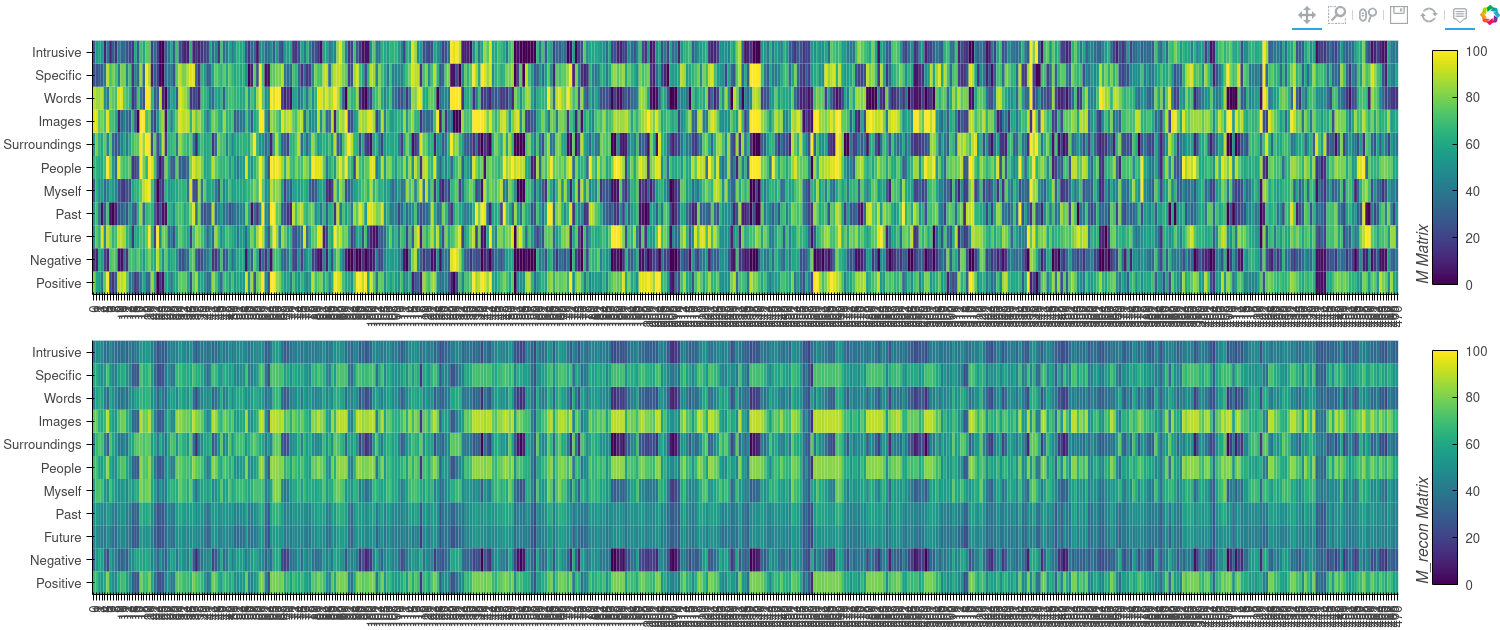

In [33]:
display.Image("./figures/S12_M_Mrecon.png")

In [34]:
question = 'People'
aux = pd.concat([Morig[question],Mrecon[question]],axis=1)
aux.columns = ['Orig','Recon']
aux.hvplot.scatter(x='Orig',y='Recon', aspect='square')

:Scatter   [Orig]   (Recon)

***

# 6. Addtional ways to visualize the data

# 6.1. Factor 2 Question relationship as horizontal barplots

Here we represent matrix Q as a series of horizonzal barplots. Questions that are on the top X percentile (dashed line) are marked in red.

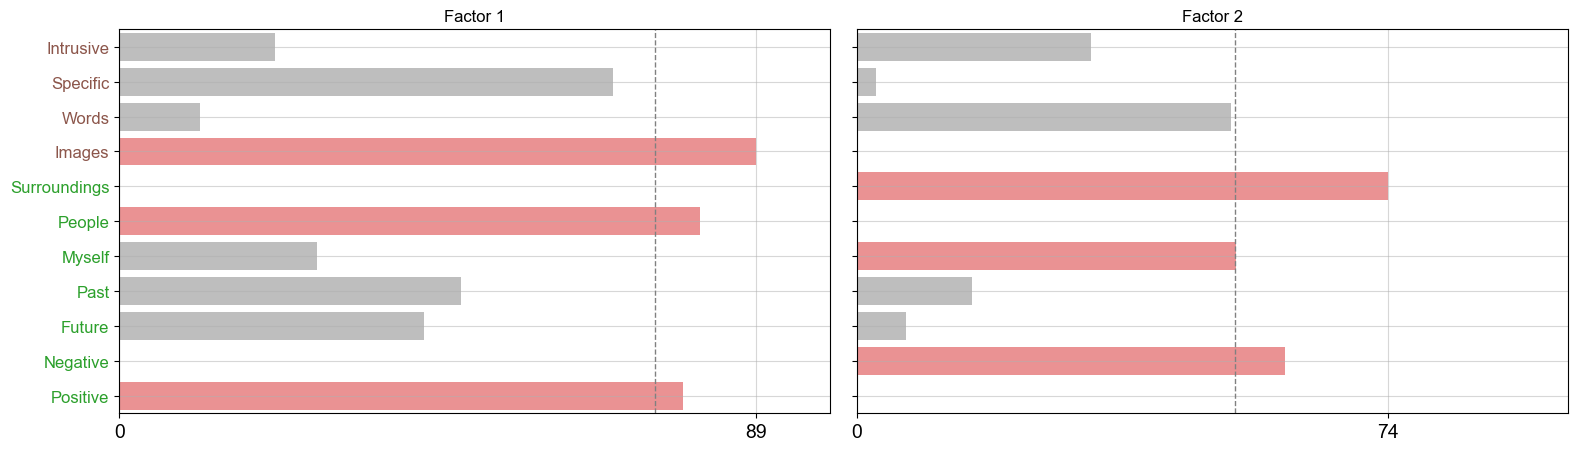

In [35]:
plot_Q_bars(Q,SNYCQ,SNYCQ_Questions, SNYCQ_Question_type)

## 6.2. W as unsorted heatmap

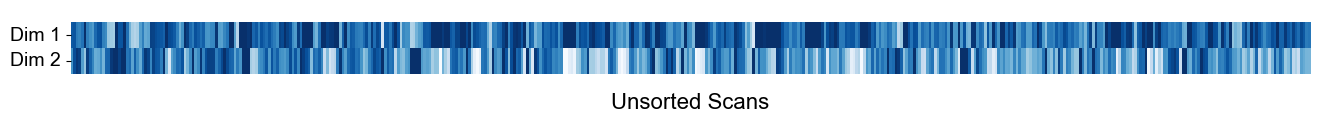

In [36]:
plot_W(W)

## 6.3. W as a scatter plot

In [37]:
f = plot_W_scatter(W, plot_hist=False, plot_kde=False, figsize=(5,5), marker_size=20)
f.get_axes()[0].grid('on')
f.savefig('./figures/S12_W_scatter_noClusters.png')

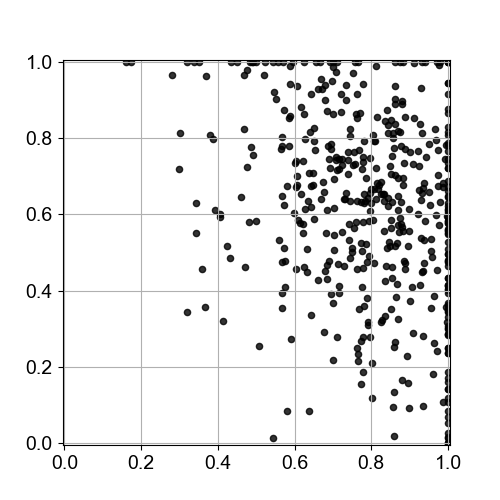

In [38]:
display.Image('./figures/S12_W_scatter_noClusters.png')

## 6.4. Plot a few representative subjects on the extremes

In [39]:
top_left_scans = W[(W['Factor 1']<0.4) & (W['Factor 2']>0.9)].index
a = SNYCQ.loc[top_left_scans].reset_index(drop=True)
a.index = a.index.astype(str)
f = a[sorted_q].hvplot.heatmap(width=250, height=250, clim=(0,100), cmap='Viridis', ylabel='Scan', xlabel='Question', fontscale=1.2).opts(colorbar=False, xrotation=90, toolbar=None)
pn.Row(f)#.save('./figures/S12_bcm_embedding_rep_highF1.png')

Row
    [0] HoloViews(HeatMap, height=250, sizing_mode='fixed', width=250)

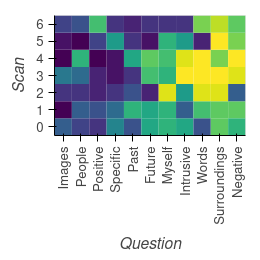

In [40]:
display.Image('./figures/S12_bcm_embedding_rep_highF1.png')

In [41]:
top_left_scans = W[(W['Factor 1']>0.8) & (W['Factor 1']<0.90) & (W['Factor 2']<0.2)].index
a = SNYCQ.loc[top_left_scans].reset_index(drop=True)
a.index = a.index.astype(str)
f = a[sorted_q].hvplot.heatmap(width=250, height=250, clim=(0,100), cmap='Viridis', ylabel='Scan', xlabel='Question', fontscale=1.2).opts(colorbar=False, xrotation=90, toolbar=None)
pn.Row(f)#.save('./figures/S12_bcm_embedding_rep_highF2.png')

Row
    [0] HoloViews(HeatMap, height=250, sizing_mode='fixed', width=250)

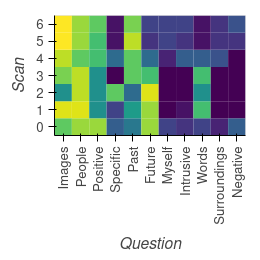

In [42]:
display.Image('./figures/S12_bcm_embedding_rep_highF2.png')

***
# 7. Clustering: looking for extremes

Even though we do not see clear clusters in the data, we will rely on agglomerative clustering to find scans sitting on the extremes of reported experience. A k=3 should provide the scans on the extremes and then a "separating" Intermediate group.

The inputs to the clustering algorithm are: 1) matrix ```W``` and 2) ```N_CLUSTERS=3```

In [43]:
N_CLUSTERS = 3
cluster_ids = cluster_scans(W, n_clusters=N_CLUSTERS)
cluster_ids = cluster_ids.astype(int)
print('++ INFO: Number of clusters = %d' % int(cluster_ids.max()+1))

++ INFO [cluster_scans]: Doing agglomerative clustering for provied k = 3
++ INFO: Number of clusters = 3


We save the clustering results in a pandas Dataframe with consistent indexing in terms of subject and scan ID

In [44]:
clusters_info = pd.DataFrame(index=W.index, columns=['Cluster ID','Cluster Label'])
clusters_info['Cluster ID'] = cluster_ids

For creating the figures it is convenient to transform randomly assigned cluster labels into labels that describe the relationship of the clusters to the underlying factors. We will use these three labels: ```Image-Pos-Others```, ```Surr-Neg-Self``` and ```Intermediate```. We use the mean F1 and F2 values to translate original numeric labels into these more meaningful categories.

In [45]:
cluster_labels_translate = {x:'Intermediate' for x in np.unique(cluster_ids)}
Waux = W.copy()
Waux['Cluster ID']    = cluster_ids
cluster_labels_translate[float(Waux.groupby('Cluster ID').mean().sort_values(by='Factor 1', ascending=False).iloc[0].name)] = 'Image-Pos-Others'
cluster_labels_translate[float(Waux.groupby('Cluster ID').mean().sort_values(by='Factor 2', ascending=False).iloc[0].name)] = 'Surr-Neg-Self'
clusters_info['Cluster Label'] = [cluster_labels_translate[c] for c in Waux['Cluster ID']]
clusters_info['Cluster ID'] = 0
clusters_info.loc[clusters_info['Cluster Label']=='Image-Pos-Others','Cluster ID'] = 1
clusters_info.loc[clusters_info['Cluster Label']=='Surr-Neg-Self','Cluster ID'] = 2
clusters_info.loc[clusters_info['Cluster Label']=='Intermediate'  ,'Cluster ID'] = 3
del Waux, cluster_ids, cluster_labels_translate

We print the number of scans per group, to ensure the extreme groups have similar sizes.

In [46]:
clusters_info.value_counts('Cluster Label')

Cluster Label
Intermediate        312
Image-Pos-Others     81
Surr-Neg-Self        78
dtype: int64

In [47]:
print('GROUP\t#Scans\t#Subjects')
for group in ['Intermediate','Image-Pos-Others','Surr-Neg-Self']:
    print('%s \t %d \t %d' % (group, 
                              len(clusters_info.reset_index().set_index('Cluster Label').loc[group,'Subject']), 
                              len(clusters_info.reset_index().set_index('Cluster Label').loc[group,'Subject'].unique())))

GROUP	#Scans	#Subjects
Intermediate 	 312 	 116
Image-Pos-Others 	 81 	 44
Surr-Neg-Self 	 78 	 46


In [48]:
sbjs = clusters_info.index.get_level_values('Subject').unique()
df = pd.DataFrame(index=sbjs, columns=['Num Scans','Image-Pos-Others','Surr-Neg-Self','Intermediate'])
for sbj in sbjs:
    aux = clusters_info.loc[sbj,:]
    df.loc[sbj,'Num Scans'] = aux.shape[0]
    aux_counts = aux['Cluster Label'].value_counts()
    for cl in ['Image-Pos-Others','Surr-Neg-Self','Intermediate']:
        if cl in aux_counts:
            df.loc[sbj,cl] = aux_counts[cl]
        else:
            df.loc[sbj,cl] = 0

In [49]:
f = plot_W_scatter(W, clusters_info=clusters_info, plot_kde=False, plot_hist=False, marker_size=20,figsize=(5,5), cluster_palette=[(1.0, 0.4980392156862745, 0.054901960784313725),
                                                                                                                                  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                                                                                                                                   (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),])
f.get_axes()[0].grid('on')
f.savefig('./figures/S12_W_scatter_withClusters.png')

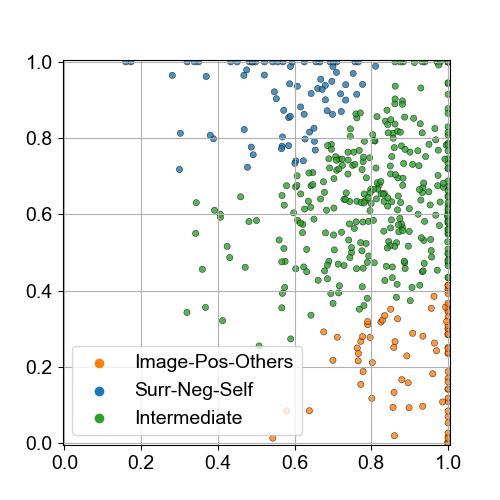

In [50]:
display.Image('./figures/S12_W_scatter_withClusters.png')

In [51]:
clusters_info.to_csv(SNYCQ_CLUSTERS_INFO_PATH)
print('++ INFO: Clustering Membership Info saved to [%s]' % SNYCQ_CLUSTERS_INFO_PATH)

++ INFO: Clustering Membership Info saved to [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/snycq/SNYCQ_clusters_info.csv]


## 7.1. Plot W sorted by clustering

Now that we have the clusters, we can group scans in M and W using this information to see how the clustering looks in terms of the original and low dimensional represenation of the data as heatmaps.

We will generate two potential clusters depending on whether we sort scans within each cluster using Factor 1 or Factor 2

In [52]:
sort_clf1f2_list = []
for cl_label in ['Image-Pos-Others','Surr-Neg-Self','Intermediate']:
    aux = pd.concat([W,clusters_info],axis=1)
    aux = aux.reset_index().set_index('Cluster Label').loc[cl_label]
    sort_clf1f2_list = sort_clf1f2_list + list(aux.sort_values(by=['Factor 1','Factor 2']).set_index(['Subject','Run']).index)
sort_clf1f2_idx = pd.Index(sort_clf1f2_list)

In [53]:
sort_clf2f1_list = []
for cl_label in ['Image-Pos-Others','Surr-Neg-Self','Intermediate']:
    aux = pd.concat([W,clusters_info],axis=1)
    aux = aux.reset_index().set_index('Cluster Label').loc[cl_label]
    sort_clf2f1_list = sort_clf2f1_list + list(aux.sort_values(by=['Factor 2','Factor 1']).set_index(['Subject','Run']).index)
sort_clf2f1_idx = pd.Index(sort_clf2f1_list)

We will plot W in two ways, horizontal and vertical. One might be more useful for manuscript figures and the otherone for talks, but the information is the same.

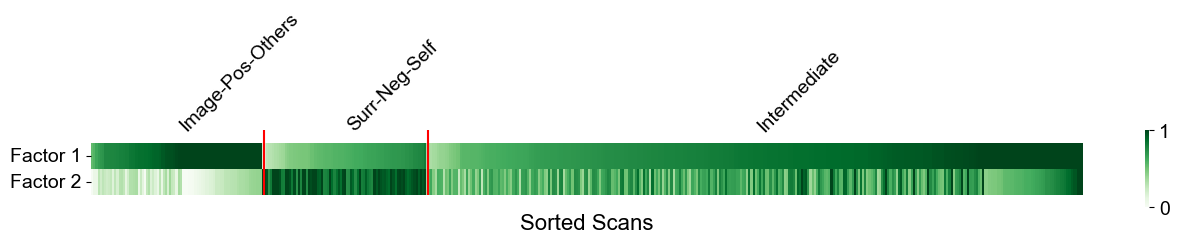

In [54]:
plot_W_heatmap(W, clusters_info=clusters_info, scan_order=sort_clf1f2_idx, cmap='Greens')

In [55]:
f=pn.Row(W.loc[sort_clf1f2_idx].reset_index(drop=True).hvplot.heatmap(cmap='Greens', ylabel='Scans', width=250, height=600, fontscale=1.2, clim=(0,1)).opts( colorbar_opts={'title':'W Matrix'}, xrotation=90, toolbar=None))
f#.save('./figures/S12_W_sorted.png')

Row
    [0] HoloViews(HeatMap, height=600, sizing_mode='fixed', width=250)

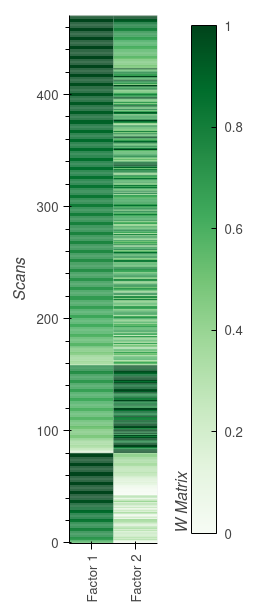

In [56]:
display.Image('./figures/S12_W_sorted.png')

## 7.2. Plot M sorted by clusters

Now we will plot the original data. We will sort questions based on the correlation analyses done while originally exploring potential relationships between questions. Sorting does not change results, it just helps with visualization, so that patterns of responses across clusters become more aparent.

In [57]:
q_order = ['Future', 'Specific', 'Past', 'Positive', 'People', 'Images', 'Words', 'Negative', 'Surroundings', 'Myself', 'Intrusive']

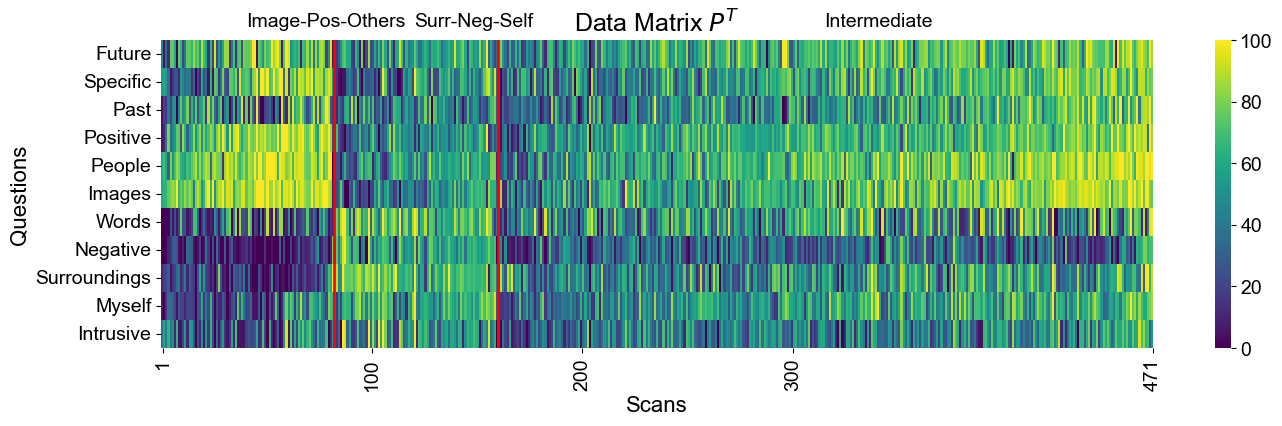

In [58]:
f = plot_P(Morig, question_order=q_order, scan_order=sort_clf1f2_idx, clusters_info=clusters_info)
f#.savefig('./figures/S12_M_by_clusters.png')

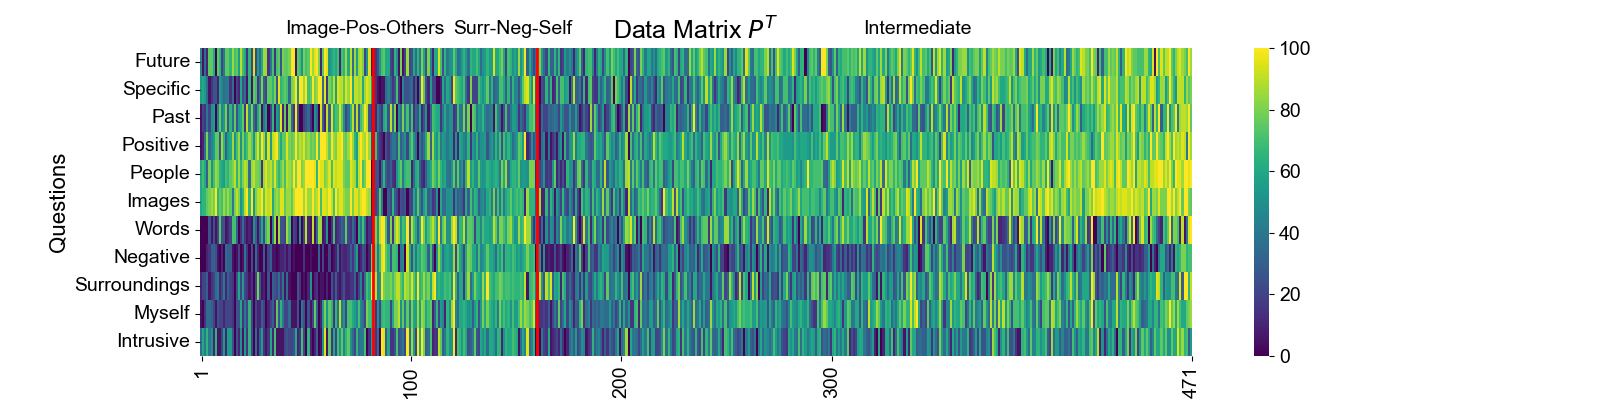

In [59]:
display.Image('./figures/S12_M_by_clusters.png')

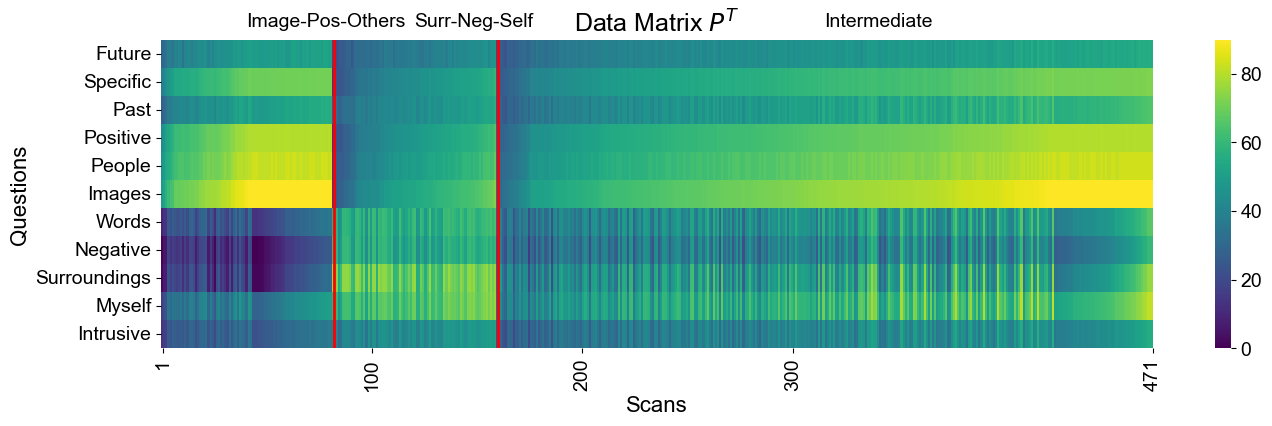

In [60]:
f = plot_P(Mrecon, question_order=q_order, scan_order=sort_clf1f2_idx, clusters_info=clusters_info)
f#.savefig('./figures/S12_Mrecon_by_clusters.png')

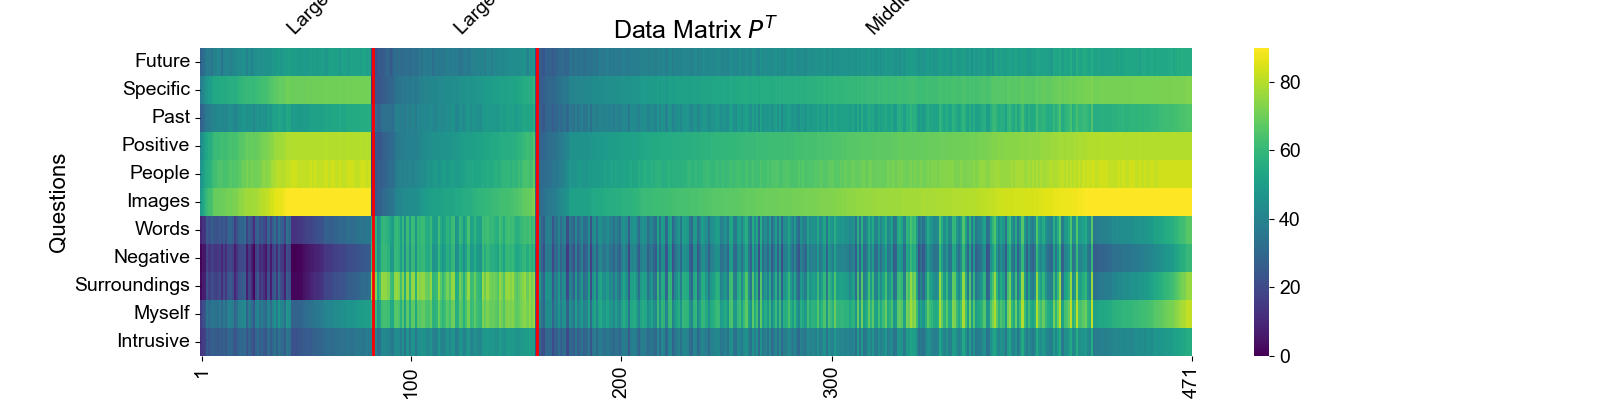

In [61]:
display.Image('./figures/Mrecon_by_clusters.png')

***
# 8. How often scans fall in the same cluster

First, we count how many scans we have per subject and keep that information on a pandas Series object

In [62]:
scans_per_subject = pd.Series(index=sbjs, dtype=int)
for sbj in scans_per_subject.index:
    aux = SNYCQ.loc[sbj,:]
    scans_per_subject[sbj] = aux.shape[0]
sbjs_3plus_scans = list(scans_per_subject[scans_per_subject > 2].index)
assert scans_per_subject.sum() == len(SCANs)

In [63]:
Nsbjs_total       = len(SNYCQ.index.get_level_values('Subject').unique())
Nsbjs_3plus_scans = len(sbjs_3plus_scans)
print('++ INFO: Initial number of subjects              : %d subjects' % Nsbjs_total)
print('++ INFO: Number of subjects with 3 or more scans : %d subjects' % Nsbjs_3plus_scans)

++ INFO: Initial number of subjects              : 133 subjects
++ INFO: Number of subjects with 3 or more scans : 116 subjects


In [64]:
selected_scans = clusters_info.loc[sbjs_3plus_scans,:]
print('++ INFO: Number of scans in this analysis: %s scans' % len(selected_scans))

++ INFO: Number of scans in this analysis: 444 scans


Now, for each participant with 3 or more scans, we check for three possible configurations:

1. All scans in the same set
2. All scans, except 1, in the same set.
3. Any other combination across the three sets

In [65]:
df = pd.DataFrame(0, index=sbjs_3plus_scans, columns=['All scans in same set','All except one scan in same set','Other configurations'], dtype=int)
for sbj in sbjs_3plus_scans:
    aux = selected_scans.loc[sbj,:]
    aux_value_counts = aux.value_counts()
    scans_for_this_subject = aux.shape[0]
    # All scans in same cluster
    if aux_value_counts.shape[0] == 1:
        df.loc[sbj,'All scans in same set'] = 1
    # Scans across 2 clusters
    elif aux_value_counts.shape[0] == 2:
        count_on_larger_set = aux_value_counts.sort_values(ascending=False).iloc[0]
        if count_on_larger_set == scans_for_this_subject - 1:
            df.loc[sbj,'All except one scan in same set'] = 1
        else:
            df.loc[sbj,'Other configurations'] = 1
    # Scans across 3 clusters --> automatically "Other scenario"
    else:
        df.loc[sbj,'Other configurations'] = 1

Finally, we obtain the subject count for each of the three scenarios

In [66]:
final_counts = df.sum()

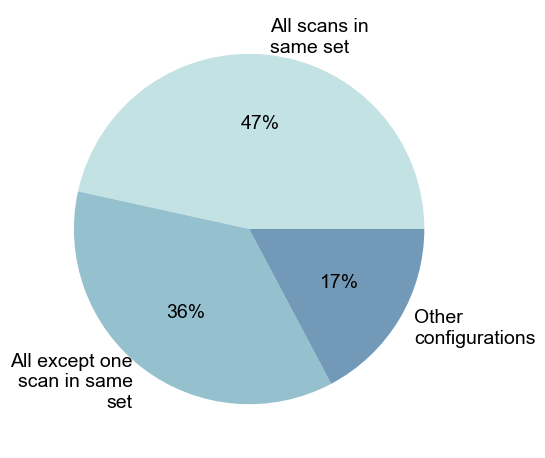

In [67]:
labels=final_counts.index
labels = [ '\n'.join(wrap(l, 15)) for l in labels ]
f = plt.pie(final_counts, colors=sns.color_palette("ch:start=.2,rot=-.3"), labels=labels,autopct='%.0f%%');
plt.tight_layout()
plt.savefig('./figures/S12_Pie_Scans_per_Subject.png',bbox_inches='tight')

***

# 9. Significant Differences in things of interest across extreme clusters

Our next analysis is looking to whether or not there are significant differences in FC across the two extreme groups. Before doing that, we will do a couple of sanity checks to ensure any differences we find we can interpret them with some degree of confidence to being due to the differerences in reported in-scanner experience.

The set of sanity checks include:

1) Check for significant differences in reported levels of wakefulness

2) Check for significant differences in head motion in terms of max motion.

3) Check for significant differneces in head motion in terms of mean motion.

First, we get the list of scans not part of the Intermediate group.

In [68]:
scans_of_interest = clusters_info[clusters_info['Cluster Label']!='Intermediate'].index

Second, we create an empty dataset that we will later populate with information about motion and wakefulness

In [69]:
df = pd.DataFrame(index = scans_of_interest,columns=['Scan Sets:','Mean Framewise Displacement','Max. Framewise Displacement','Wakefulness'])

## 9.1. Significant differences in wakefulness levels?

Load again the original SNYCQ data. The reason for this is that earlier on the notebook we removed the answers to the wakefulness question, which is the one we need now.

In [70]:
_,_,aux_snycq = get_sbj_scan_list(when='post_motion')

++ [post_motion] Number of subjects: 133 subjects
++ [post_motion] Number of scans:    471 scans


Add the wakefulness answer to the temporary dataframe df

In [71]:
for scan in df.index:
    df.loc[scan,'Wakefulness'] = aux_snycq.loc[scan,'Vigilance']
    df.loc[scan,'Scan Sets:'] = clusters_info.loc[scan,'Cluster Label']
df = df.infer_objects()
df.head(5)

Scan Sets:  \
Subject    Run                                           
sub-010014 post-ses-02-run-02-acq-AP     Surr-Neg-Self   
           post-ses-02-run-02-acq-PA     Surr-Neg-Self   
sub-010080 post-ses-02-run-02-acq-PA  Image-Pos-Others   
sub-010082 post-ses-02-run-01-acq-AP     Surr-Neg-Self   
           post-ses-02-run-01-acq-PA     Surr-Neg-Self   

                                      Mean Framewise Displacement  \
Subject    Run                                                      
sub-010014 post-ses-02-run-02-acq-AP                          NaN   
           post-ses-02-run-02-acq-PA                          NaN   
sub-010080 post-ses-02-run-02-acq-PA                          NaN   
sub-010082 post-ses-02-run-01-acq-AP                          NaN   
           post-ses-02-run-01-acq-PA                          NaN   

                                      Max. Framewise Displacement  Wakefulness  
Subject    Run                                                                  
sub-010014 post-ses-02-run-02-acq-AP                          NaN         40.0  
           post-ses-02-run-02-acq-PA                          NaN         40.0  
sub-010080 post-ses-02-run-02-acq-PA                          NaN         90.0  
sub-010082 post-ses-02-run-01-acq-AP                          NaN         75.0  
           post-ses-02-run-01-acq-PA                          NaN         70.0

In [72]:
f = df.hvplot.kde(y='Wakefulness',by='Scan Sets:', alpha=.5, title='Wakefulness', color=['#4472C4','#ED7D31'], width=400, height=200,
                  fontsize={'xticks':15,'yticks':15,'xlabel':15,'ylabel':15,'legend':10, 'title':20}).opts(legend_position='bottom_right', toolbar=None, show_legend=True, show_title=False)
pn.Row(f)#.save('./figures/S12_Clusters_Wakefulness_KDEs.png')

Row
    [0] HoloViews(NdOverlay, height=200, sizing_mode='fixed', width=400)

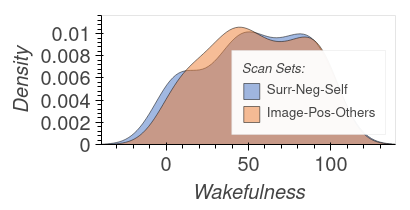

In [73]:
display.Image('./figures/S12_Clusters_Wakefulness_KDEs.png')

In [74]:
f = df.hvplot.hist(y='Wakefulness',by='Scan Sets:', alpha=.5, title='Wakefulness', color=['#ED7D31','#4472C4'], width=400, height=200, ylabel='# Scans',
                  fontsize={'xticks':15,'yticks':15,'xlabel':15,'ylabel':15,'legend':10, 'title':20}).opts(legend_position='top_left', toolbar=None, show_legend=True, show_title=False, legend_cols=2, legend_padding=1)
pn.Row(f)#.save('./figures/S12_Clusters_Wakefulness_HISTs.png')

Row
    [0] HoloViews(NdOverlay, height=200, sizing_mode='fixed', width=400)

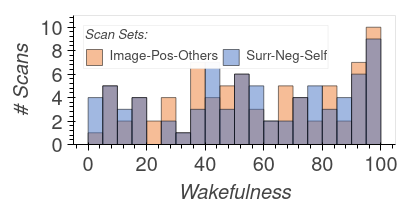

In [75]:
display.Image('./figures/S12_Clusters_Wakefulness_HISTs.png')

In [76]:
ttest_ind(df.set_index('Scan Sets:').loc['Image-Pos-Others','Wakefulness'],df.set_index('Scan Sets:').loc['Surr-Neg-Self','Wakefulness'],alternative='two-sided')

Ttest_indResult(statistic=0.1624613787828161, pvalue=0.8711514489317592)

In [77]:
mannwhitneyu(df.set_index('Scan Sets:').loc['Image-Pos-Others','Wakefulness'],df.set_index('Scan Sets:').loc['Surr-Neg-Self','Wakefulness'],alternative='two-sided')

MannwhitneyuResult(statistic=3184.5, pvalue=0.9312493425517473)

## 9.2. Significance differnces in head motion?

We now add the information about motion

In [78]:
for scan in df.index:
    sbj,run = scan
    _,_,_,_,run_num,_,run_acq = run.split('-')
    path = osp.join(DATA_DIR,'PrcsData',sbj,'preprocessed','func','pb01_moco','_scan_id_ses-02_task-rest_acq-{run_acq}_run-{run_num}_bold'.format(run_num=run_num,run_acq=run_acq),'rest_realigned_rel.rms')
    mot  = np.loadtxt(path)
    df.loc[scan,'Mean Framewise Displacement'] = mot.mean()
    df.loc[scan,'Max. Framewise Displacement']  = mot.max()
df = df.infer_objects()
df.head(5)

Scan Sets:  \
Subject    Run                                           
sub-010014 post-ses-02-run-02-acq-AP     Surr-Neg-Self   
           post-ses-02-run-02-acq-PA     Surr-Neg-Self   
sub-010080 post-ses-02-run-02-acq-PA  Image-Pos-Others   
sub-010082 post-ses-02-run-01-acq-AP     Surr-Neg-Self   
           post-ses-02-run-01-acq-PA     Surr-Neg-Self   

                                      Mean Framewise Displacement  \
Subject    Run                                                      
sub-010014 post-ses-02-run-02-acq-AP                     0.119261   
           post-ses-02-run-02-acq-PA                     0.082769   
sub-010080 post-ses-02-run-02-acq-PA                     0.103407   
sub-010082 post-ses-02-run-01-acq-AP                     0.124239   
           post-ses-02-run-01-acq-PA                     0.072078   

                                      Max. Framewise Displacement  Wakefulness  
Subject    Run                                                                  
sub-010014 post-ses-02-run-02-acq-AP                     2.303230         40.0  
           post-ses-02-run-02-acq-PA                     1.429000         40.0  
sub-010080 post-ses-02-run-02-acq-PA                     1.641530         90.0  
sub-010082 post-ses-02-run-01-acq-AP                     0.238719         75.0  
           post-ses-02-run-01-acq-PA                     0.293759         70.0

In [79]:
f_mean_mot = df.hvplot.kde(y='Mean Framewise Displacement',by='Scan Sets:', alpha=.5, 
                   title='Head Motion',color=['#4472C4','#ED7D31'], width=400, height=200,
                  fontsize={'xticks':15,'yticks':15,'xlabel':15,'ylabel':15,'legend':8}).opts(legend_position='bottom_right', toolbar=None, show_title=False, show_legend=True)
f_max_mot = df.hvplot.kde(y='Max. Framewise Displacement',by='Scan Sets:', alpha=.5, title='Head Motion',color=['#4472C4','#ED7D31'], width=400,
                  fontsize={'xticks':15,'yticks':15,'xlabel':15,'ylabel':15,'legend':12}).opts(legend_position='bottom_right', toolbar=None)
pn.Row(f_mean_mot)#.save('./figures/S12_Clusters_Motion_KDEs.png')

Row
    [0] HoloViews(NdOverlay, height=200, sizing_mode='fixed', width=400)

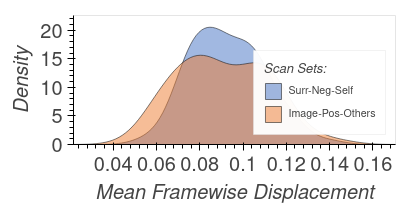

In [80]:
display.Image('./figures/S12_Clusters_Motion_KDEs.png')

In [81]:
f_mean_mot = df.hvplot.hist(y='Mean Framewise Displacement',by='Scan Sets:', alpha=.5, 
                   title='Head Motion',color=['#ED7D31','#4472C4'], width=400, height=200, ylabel='# Scans', ylim=(0,18),
                  fontsize={'xticks':15,'yticks':15,'xlabel':15,'ylabel':15,'legend':12}).opts(legend_position='top_left', toolbar=None, show_legend=True, show_title=False, legend_cols=1, legend_padding=1)
f_max_mot = df.hvplot.hist(y='Max. Framewise Displacement',by='Scan Sets:', alpha=.5, title='Head Motion',color=['#4472C4','#ED7D31'], width=400,
                  fontsize={'xticks':15,'yticks':15,'xlabel':15,'ylabel':15,'legend':12}).opts(legend_position='bottom_right', toolbar=None)
pn.Row(f_mean_mot)#.save('./figures/S12_Clusters_Motion_HISTs.png')

Row
    [0] HoloViews(NdOverlay, height=200, sizing_mode='fixed', width=400)

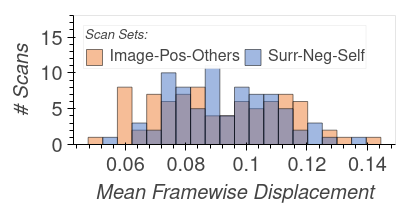

In [82]:
display.Image('./figures/S12_Clusters_Motion_HISTs.png')

In [83]:
ttest_ind(df.set_index('Scan Sets:').loc['Image-Pos-Others','Mean Framewise Displacement'],df.set_index('Scan Sets:').loc['Surr-Neg-Self','Mean Framewise Displacement'],alternative='two-sided')

Ttest_indResult(statistic=-0.6065857705306705, pvalue=0.5450019704419318)

In [84]:
mannwhitneyu(df.set_index('Scan Sets:').loc['Image-Pos-Others','Mean Framewise Displacement'],df.set_index('Scan Sets:').loc['Surr-Neg-Self','Mean Framewise Displacement'],alternative='two-sided')

MannwhitneyuResult(statistic=2967.0, pvalue=0.5093848277147455)

## 9.3. Gender distribution by scan set

In [85]:
assert np.all(C.index == clusters_info.index), "++ ERROR: Can't proceed as the two indexes are not equal."

In [86]:
D = C.copy()
D['Cluster Label'] = clusters_info['Cluster Label']
scans_per_group = {group:D.reset_index().set_index('Cluster Label').loc[group].reset_index().set_index(['Subject','Run']) for group in ['Image-Pos-Others','Surr-Neg-Self']}

#### Scans / Subjects on Image-Pos-Others set

In [87]:
scans_per_group['Image-Pos-Others']

Cluster Label  Intercept  \
Subject    Run                                                      
sub-010080 post-ses-02-run-02-acq-PA  Image-Pos-Others        1.0   
sub-010098 post-ses-02-run-02-acq-AP  Image-Pos-Others        1.0   
sub-010101 post-ses-02-run-01-acq-AP  Image-Pos-Others        1.0   
sub-010018 post-ses-02-run-01-acq-AP  Image-Pos-Others        1.0   
           post-ses-02-run-01-acq-PA  Image-Pos-Others        1.0   
...                                                ...        ...   
sub-010072 post-ses-02-run-02-acq-PA  Image-Pos-Others        1.0   
sub-010076 post-ses-02-run-01-acq-AP  Image-Pos-Others        1.0   
sub-010077 post-ses-02-run-01-acq-AP  Image-Pos-Others        1.0   
           post-ses-02-run-01-acq-PA  Image-Pos-Others        1.0   
           post-ses-02-run-02-acq-AP  Image-Pos-Others        1.0   

                                      Age (younger)  Age (elder)  Gender (M)  \
Subject    Run                                                                 
sub-010080 post-ses-02-run-02-acq-PA       0.642857     0.357143         0.0   
sub-010098 post-ses-02-run-02-acq-AP       0.785714     0.214286         0.0   
sub-010101 post-ses-02-run-01-acq-AP       0.928571     0.071429         0.0   
sub-010018 post-ses-02-run-01-acq-AP       0.785714     0.214286         1.0   
           post-ses-02-run-01-acq-PA       0.785714     0.214286         1.0   
...                                             ...          ...         ...   
sub-010072 post-ses-02-run-02-acq-PA       0.785714     0.214286         1.0   
sub-010076 post-ses-02-run-01-acq-AP       0.785714     0.214286         0.0   
sub-010077 post-ses-02-run-01-acq-AP       0.928571     0.071429         0.0   
           post-ses-02-run-01-acq-PA       0.928571     0.071429         0.0   
           post-ses-02-run-02-acq-AP       0.928571     0.071429         0.0   

                                      Gender (F)  
Subject    Run                                    
sub-010080 post-ses-02-run-02-acq-PA         1.0  
sub-010098 post-ses-02-run-02-acq-AP         1.0  
sub-010101 post-ses-02-run-01-acq-AP         1.0  
sub-010018 post-ses-02-run-01-acq-AP         0.0  
           post-ses-02-run-01-acq-PA         0.0  
...                                          ...  
sub-010072 post-ses-02-run-02-acq-PA         0.0  
sub-010076 post-ses-02-run-01-acq-AP         1.0  
sub-010077 post-ses-02-run-01-acq-AP         1.0  
           post-ses-02-run-01-acq-PA         1.0  
           post-ses-02-run-02-acq-AP         1.0  

[81 rows x 6 columns]

#### Scans / Subjects on Surr-Neg-Self set

In [88]:
scans_per_group['Surr-Neg-Self']

Cluster Label  Intercept  Age (younger)  \
Subject    Run                                                                  
sub-010014 post-ses-02-run-02-acq-AP  Surr-Neg-Self        1.0       0.928571   
           post-ses-02-run-02-acq-PA  Surr-Neg-Self        1.0       0.928571   
sub-010082 post-ses-02-run-01-acq-AP  Surr-Neg-Self        1.0       0.785714   
           post-ses-02-run-01-acq-PA  Surr-Neg-Self        1.0       0.785714   
sub-010015 post-ses-02-run-01-acq-AP  Surr-Neg-Self        1.0       0.928571   
...                                             ...        ...            ...   
sub-010060 post-ses-02-run-01-acq-PA  Surr-Neg-Self        1.0       0.642857   
           post-ses-02-run-02-acq-AP  Surr-Neg-Self        1.0       0.642857   
sub-010011 post-ses-02-run-01-acq-PA  Surr-Neg-Self        1.0       0.785714   
           post-ses-02-run-02-acq-AP  Surr-Neg-Self        1.0       0.785714   
sub-010068 post-ses-02-run-02-acq-AP  Surr-Neg-Self        1.0       0.785714   

                                      Age (elder)  Gender (M)  Gender (F)  
Subject    Run                                                             
sub-010014 post-ses-02-run-02-acq-AP     0.071429         1.0         0.0  
           post-ses-02-run-02-acq-PA     0.071429         1.0         0.0  
sub-010082 post-ses-02-run-01-acq-AP     0.214286         0.0         1.0  
           post-ses-02-run-01-acq-PA     0.214286         0.0         1.0  
sub-010015 post-ses-02-run-01-acq-AP     0.071429         1.0         0.0  
...                                           ...         ...         ...  
sub-010060 post-ses-02-run-01-acq-PA     0.357143         1.0         0.0  
           post-ses-02-run-02-acq-AP     0.357143         1.0         0.0  
sub-010011 post-ses-02-run-01-acq-PA     0.214286         0.0         1.0  
           post-ses-02-run-02-acq-AP     0.214286         0.0         1.0  
sub-010068 post-ses-02-run-02-acq-AP     0.214286         0.0         1.0  

[78 rows x 6 columns]

#### Gender counts per set when only counting scans a single time per subject

In [89]:
gender_counts = pd.concat([scans_per_group['Image-Pos-Others'].reset_index().drop_duplicates('Subject').sum()[['Gender (M)','Gender (F)']],
                scans_per_group['Surr-Neg-Self'].reset_index().drop_duplicates('Subject').sum()[['Gender (M)','Gender (F)']]],axis=1)
gender_counts.columns    = ['Image-Pos-Others','Surr-Neg-Self']
gender_counts = gender_counts.T.reset_index()
gender_counts.columns    = ['Scan Set','Male','Female']
gender_counts = gender_counts.infer_objects()
gender_counts

,Scan Set,Male,Female
0,Image-Pos-Others,27.0,17.0
1,Surr-Neg-Self,21.0,25.0


In [90]:
f_gender = gender_counts.hvplot(x='Scan Set', kind='bar', stacked=True, color=['white','lightgray'], ylabel='# Subjects', width=400, height=200,fontsize={'xticks':15,'yticks':15,'xlabel':15,'ylabel':15,'legend':12}, xlabel='').opts(toolbar=None, legend_position='bottom_right', legend_cols=2)
pn.Row(f_gender)

Row
    [0] HoloViews(Bars, height=200, sizing_mode='fixed', width=400)

#### Gender counts per set when counting every scan as many times as it appears (independently if repeated subject)

In [91]:
D = C.copy()
D['Cluster Label'] = clusters_info['Cluster Label']
unique_subjects_per_group = {group:D.reset_index().set_index('Cluster Label').loc[group,'Subject'].unique() for group in ['Image-Pos-Others','Surr-Neg-Self']}
print('++ Number of subjects in Image-Pos-Others --> %d subjects / %d scans' % (unique_subjects_per_group['Image-Pos-Others'].shape[0], D.reset_index().set_index('Cluster Label').loc['Image-Pos-Others','Subject'].shape[0]))
print('++ Number of subjects in Image-Pos-Others --> %d subjects / %d scans' % (unique_subjects_per_group['Surr-Neg-Self'].shape[0], D.reset_index().set_index('Cluster Label').loc['Surr-Neg-Self','Subject'].shape[0]))
print('++ Subjects that appear in both groups --> %s ' % np.intersect1d(D.reset_index().set_index('Cluster Label').loc['Image-Pos-Others','Subject'].unique(),D.reset_index().set_index('Cluster Label').loc['Surr-Neg-Self','Subject'].unique()))

++ Number of subjects in Image-Pos-Others --> 44 subjects / 81 scans
++ Number of subjects in Image-Pos-Others --> 46 subjects / 78 scans
++ Subjects that appear in both groups --> ['sub-010060' 'sub-010098' 'sub-010101' 'sub-010147' 'sub-010173'
 'sub-010216' 'sub-010224'] 


In [92]:
demo_gender = C.copy()
demo_gender['Cluster Label'] = clusters_info['Cluster Label']
demo_gender = demo_gender.reset_index().set_index(['Subject','Run','Cluster Label'])

In [93]:
demo_gender.drop(['Intercept','Age (younger)','Age (elder)'], axis=1, inplace=True)
demo_gender = demo_gender.loc[:,:,['Surr-Neg-Self','Image-Pos-Others']]

In [94]:
demo_gender.columns = ['Male','Female']

In [95]:
demo_gender.index.names = ['Subject','Run','Scan Set']

In [96]:
demo_gender.reset_index(inplace=True)
demo_gender.drop(['Subject','Run'],inplace=True,axis=1)

In [97]:
demo_gender = demo_gender.groupby('Scan Set').sum().reset_index()

In [98]:
demo_gender = demo_gender.sort_values(by='Scan Set', ascending=False)

In [99]:
demo_gender

,Scan Set,Male,Female
1,Surr-Neg-Self,38.0,40.0
0,Image-Pos-Others,48.0,33.0


In [100]:
demo_gender.sum()

Scan Set    Surr-Neg-SelfImage-Pos-Others
Male                                 86.0
Female                               73.0
dtype: object

In [101]:
f_gender = demo_gender.hvplot(x='Scan Set', kind='bar', stacked=True, color=['white','lightgray'], ylabel='# Scans', width=400, height=200,fontsize={'xticks':15,'yticks':15,'xlabel':15,'ylabel':15,'legend':12}, xlabel='').opts(toolbar=None, legend_position='bottom_right', legend_cols=2)
pn.Row(f_gender)#.save('./figures/S12_Clusters_Gender.png')

Row
    [0] HoloViews(Bars, height=200, sizing_mode='fixed', width=400)

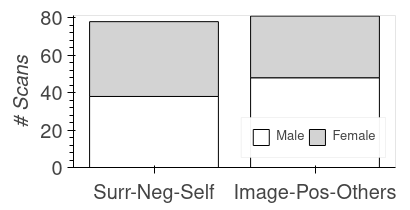

In [102]:
display.Image('./figures/S12_Clusters_Gender.png')

## 9.4. Age distribution

In [132]:
demo_age = pd.read_csv('./mlt/data/participants_post_motion_QA.csv', index_col=['Subject'])
demo_age.head(5)

,gender,age (5-year bins)
Subject,,
sub-010014,M,20-25
sub-010080,F,30-35
sub-010082,F,25-30
sub-010084,F,20-25
sub-010015,M,20-25


#### Counting only once per subject

In [133]:
img_pos_others_SBJs = list(scans_per_group['Image-Pos-Others'].index.get_level_values('Subject').unique())
sur_neg_self_SBJs   = list(scans_per_group['Surr-Neg-Self'].index.get_level_values('Subject').unique())

Adding the cluster label to the demo_age dataframe

In [134]:
demo_age['Cluster Label'] = 'Unknown'
for sbj in img_pos_others_SBJs:
    demo_age.loc[sbj,'Cluster Label'] = 'Image-Pos-Others'
for sbj in sur_neg_self_SBJs:
    demo_age.loc[sbj,'Cluster Label'] = 'Surr-Neg-Self'
demo_age = demo_age.infer_objects()
demo_age

,gender,age (5-year bins),Cluster Label
Subject,,,
sub-010014,M,20-25,Surr-Neg-Self
sub-010080,F,30-35,Image-Pos-Others
sub-010082,F,25-30,Surr-Neg-Self
sub-010084,F,20-25,Unknown
sub-010015,M,20-25,Surr-Neg-Self
...,...,...,...
sub-010073,M,20-25,Unknown
sub-010075,F,20-25,Unknown
sub-010076,F,25-30,Image-Pos-Others


In [135]:
demo_age = demo_age.drop('gender',axis=1)
demo_age.reset_index(drop=True,inplace=True)
demo_age = demo_age[demo_age['Cluster Label']!='Unknown']
demo_age

,age (5-year bins),Cluster Label
0,20-25,Surr-Neg-Self
1,30-35,Image-Pos-Others
2,25-30,Surr-Neg-Self
4,20-25,Surr-Neg-Self
6,30-35,Surr-Neg-Self
...,...,...
125,20-25,Image-Pos-Others
126,25-30,Image-Pos-Others
127,25-30,Image-Pos-Others
130,25-30,Image-Pos-Others


In [136]:
age_distributions = demo_age.groupby('Cluster Label').value_counts()
age_distributions = pd.DataFrame(age_distributions)
age_distributions = age_distributions.sort_index(level=0, ascending=False)
age_distributions

0
Cluster Label    age (5-year bins)    
Surr-Neg-Self    45-50               1
                 40-45               2
                 30-35               5
                 25-30              21
                 20-25              17
Image-Pos-Others 60-65               1
                 40-45               1
                 35-40               3
                 30-35               4
                 25-30              18
                 20-25              10

In [137]:
age_ranges = age_distributions.index.get_level_values('age (5-year bins)').unique().sort_values()
age_ranges

Index(['20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '60-65'], dtype='object', name='age (5-year bins)')

In [138]:
for cluster in ['Image-Pos-Others','Surr-Neg-Self']:
    for age_range in age_ranges:
        try:
            selection = age_distributions.loc[cluster,age_range]
        except:
            age_distributions.loc[(cluster,age_range),0]=0
age_distributions = age_distributions.sort_index()
age_distributions = age_distributions.astype(int)
age_distributions.columns = ['# Subjects']

In [139]:
age_distributions

# Subjects
Cluster Label    age (5-year bins)            
Image-Pos-Others 20-25                      10
                 25-30                      18
                 30-35                       4
                 35-40                       3
                 40-45                       1
                 45-50                       0
                 60-65                       1
Surr-Neg-Self    20-25                      17
                 25-30                      21
                 30-35                       5
                 35-40                       0
                 40-45                       2
                 45-50                       1
                 60-65                       0

In [140]:
ttest_rel(age_distributions.loc['Image-Pos-Others',:],age_distributions.loc['Surr-Neg-Self',:], alternative='two-sided')

Ttest_relResult(statistic=array([-1.08086504]), pvalue=array([0.32127539]))

In [141]:
wilcoxon(age_distributions.loc['Image-Pos-Others',:],age_distributions.loc['Surr-Neg-Self',:], alternative='two-sided', method='exact')

WilcoxonResult(statistic=array([8.]), pvalue=array([0.375]))

In [142]:
age_distributions = age_distributions.reset_index()
age_distributions.columns = ['Scan Set','Age Range','# Subjects']
age_distributions['color'] = 'white'
age_distributions.loc[age_distributions['Scan Set']=='Image-Pos-Others','color'] = 'orange'
age_distributions.loc[age_distributions['Scan Set']=='Surr-Neg-Self','color'] = 'lightblue'
age_distributions = age_distributions.infer_objects()

In [143]:
f_age = age_distributions.hvplot(kind='bar',x='Scan Set',by='Age Range',fontsize={'xticks':12,'yticks':15,'xlabel':12,'ylabel':15,'legend':12},width=600, height=200,  stacked=False, grid=True, xlabel='', color='color').opts(xrotation=90, toolbar=None)
pn.Row(f_age)

Row
    [0] HoloViews(Bars, height=200, sizing_mode='fixed', width=600)

<Axes: xlabel='Age Range', ylabel='# Subjects'>

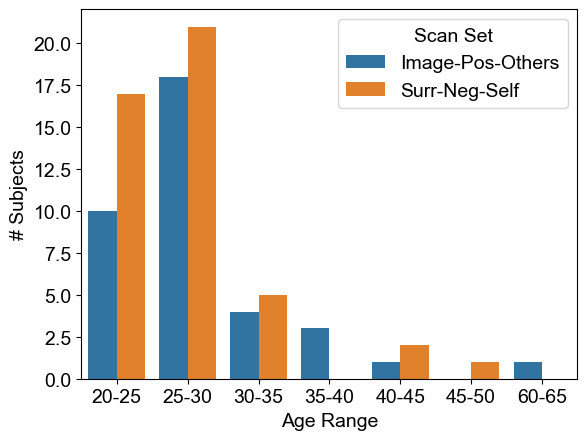

In [144]:
sns.barplot(data=age_distributions, y='# Subjects', hue='Scan Set', x='Age Range' )

#### Counting each scan as its onw unit

In [145]:
demo_age = pd.read_csv('./mlt/data/participants_post_motion_QA.csv', index_col=['Subject'])
demo_age

,gender,age (5-year bins)
Subject,,
sub-010014,M,20-25
sub-010080,F,30-35
sub-010082,F,25-30
sub-010084,F,20-25
sub-010015,M,20-25
...,...,...
sub-010073,M,20-25
sub-010075,F,20-25
sub-010076,F,25-30


In [146]:
for group in ['Image-Pos-Others','Surr-Neg-Self']:
    scans_per_group[group]['age (5-year bins)'] = None
    for i,row in scans_per_group[group].iterrows():
        scans_per_group[group].loc[i,'age (5-year bins)'] = demo_age.loc[i[0]]['age (5-year bins)']

In [147]:
scans_per_group[group]

Cluster Label  Intercept  Age (younger)  \
Subject    Run                                                                  
sub-010014 post-ses-02-run-02-acq-AP  Surr-Neg-Self        1.0       0.928571   
           post-ses-02-run-02-acq-PA  Surr-Neg-Self        1.0       0.928571   
sub-010082 post-ses-02-run-01-acq-AP  Surr-Neg-Self        1.0       0.785714   
           post-ses-02-run-01-acq-PA  Surr-Neg-Self        1.0       0.785714   
sub-010015 post-ses-02-run-01-acq-AP  Surr-Neg-Self        1.0       0.928571   
...                                             ...        ...            ...   
sub-010060 post-ses-02-run-01-acq-PA  Surr-Neg-Self        1.0       0.642857   
           post-ses-02-run-02-acq-AP  Surr-Neg-Self        1.0       0.642857   
sub-010011 post-ses-02-run-01-acq-PA  Surr-Neg-Self        1.0       0.785714   
           post-ses-02-run-02-acq-AP  Surr-Neg-Self        1.0       0.785714   
sub-010068 post-ses-02-run-02-acq-AP  Surr-Neg-Self        1.0       0.785714   

                                      Age (elder)  Gender (M)  Gender (F)  \
Subject    Run                                                              
sub-010014 post-ses-02-run-02-acq-AP     0.071429         1.0         0.0   
           post-ses-02-run-02-acq-PA     0.071429         1.0         0.0   
sub-010082 post-ses-02-run-01-acq-AP     0.214286         0.0         1.0   
           post-ses-02-run-01-acq-PA     0.214286         0.0         1.0   
sub-010015 post-ses-02-run-01-acq-AP     0.071429         1.0         0.0   
...                                           ...         ...         ...   
sub-010060 post-ses-02-run-01-acq-PA     0.357143         1.0         0.0   
           post-ses-02-run-02-acq-AP     0.357143         1.0         0.0   
sub-010011 post-ses-02-run-01-acq-PA     0.214286         0.0         1.0   
           post-ses-02-run-02-acq-AP     0.214286         0.0         1.0   
sub-010068 post-ses-02-run-02-acq-AP     0.214286         0.0         1.0   

                                     age (5-year bins)  
Subject    Run                                          
sub-010014 post-ses-02-run-02-acq-AP             20-25  
           post-ses-02-run-02-acq-PA             20-25  
sub-010082 post-ses-02-run-01-acq-AP             25-30  
           post-ses-02-run-01-acq-PA             25-30  
sub-010015 post-ses-02-run-01-acq-AP             20-25  
...                                                ...  
sub-010060 post-ses-02-run-01-acq-PA             30-35  
           post-ses-02-run-02-acq-AP             30-35  
sub-010011 post-ses-02-run-01-acq-PA             25-30  
           post-ses-02-run-02-acq-AP             25-30  
sub-010068 post-ses-02-run-02-acq-AP             25-30  

[78 rows x 7 columns]

Adding the cluster label to the demo_age dataframe

In [148]:
demo_age = pd.concat([scans_per_group['Image-Pos-Others'],scans_per_group['Surr-Neg-Self']],axis=0).reset_index()[['age (5-year bins)','Cluster Label']]
demo_age = demo_age.infer_objects()
demo_age

,age (5-year bins),Cluster Label
0,30-35,Image-Pos-Others
1,25-30,Image-Pos-Others
2,20-25,Image-Pos-Others
3,25-30,Image-Pos-Others
4,25-30,Image-Pos-Others
...,...,...
154,30-35,Surr-Neg-Self
155,30-35,Surr-Neg-Self
156,25-30,Surr-Neg-Self
157,25-30,Surr-Neg-Self


In [149]:
age_distributions = demo_age.groupby('Cluster Label').value_counts()
age_distributions = pd.DataFrame(age_distributions)
age_distributions = age_distributions.sort_index(level=0, ascending=False)
age_distributions

0
Cluster Label    age (5-year bins)    
Surr-Neg-Self    45-50               2
                 40-45               8
                 30-35               9
                 25-30              31
                 20-25              28
Image-Pos-Others 60-65               1
                 40-45               4
                 35-40               5
                 30-35               8
                 25-30              36
                 20-25              27

In [150]:
age_ranges = age_distributions.index.get_level_values('age (5-year bins)').unique().sort_values()
age_ranges

Index(['20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '60-65'], dtype='object', name='age (5-year bins)')

In [151]:
for cluster in ['Image-Pos-Others','Surr-Neg-Self']:
    for age_range in age_ranges:
        try:
            selection = age_distributions.loc[cluster,age_range]
        except:
            age_distributions.loc[(cluster,age_range),0]=0
age_distributions = age_distributions.sort_index()
age_distributions = age_distributions.astype(int)
age_distributions.columns = ['# Subjects']

In [152]:
age_distributions

# Subjects
Cluster Label    age (5-year bins)            
Image-Pos-Others 20-25                      27
                 25-30                      36
                 30-35                       8
                 35-40                       5
                 40-45                       4
                 45-50                       0
                 60-65                       1
Surr-Neg-Self    20-25                      28
                 25-30                      31
                 30-35                       9
                 35-40                       0
                 40-45                       8
                 45-50                       2
                 60-65                       0

In [153]:
ttest_rel(age_distributions.loc['Image-Pos-Others',:],age_distributions.loc['Surr-Neg-Self',:], alternative='two-sided')

Ttest_relResult(statistic=array([0.32797823]), pvalue=array([0.75407096]))

In [154]:
wilcoxon(age_distributions.loc['Image-Pos-Others',:],age_distributions.loc['Surr-Neg-Self',:], alternative='two-sided', method='exact')

WilcoxonResult(statistic=array([13.]), pvalue=array([0.9375]))

In [155]:
age_distributions = age_distributions.reset_index()
age_distributions.columns = ['Scan Set','Age Range','# Scans']
age_distributions['color'] = 'white'
age_distributions.loc[age_distributions['Scan Set']=='Image-Pos-Others','color'] = 'orange'
age_distributions.loc[age_distributions['Scan Set']=='Surr-Neg-Self','color'] = 'lightblue'
age_distributions = age_distributions.infer_objects()

In [156]:
f_age = age_distributions.hvplot(kind='bar',x='Scan Set',by='Age Range',fontsize={'xticks':12,'yticks':15,'xlabel':12,'ylabel':15,'legend':12},width=600, height=200,  stacked=False, grid=True, xlabel='', color='color').opts(xrotation=90, toolbar=None)
pn.Row(f_age)

Row
    [0] HoloViews(Bars, height=200, sizing_mode='fixed', width=600)

<Axes: xlabel='Age Range', ylabel='# Scans'>

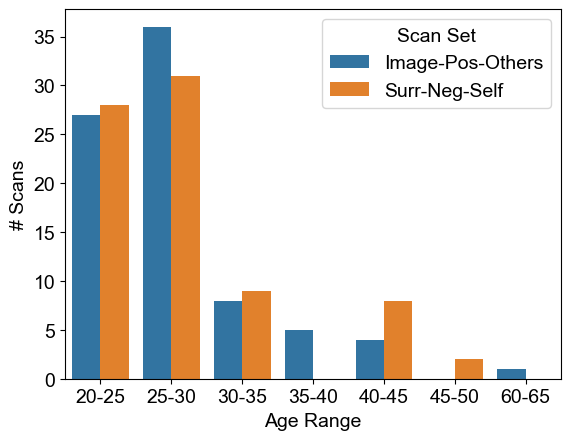

In [157]:
sns.barplot(data=age_distributions, y='# Scans', hue='Scan Set', x='Age Range' )

In [129]:
demo_age = pd.read_csv('./mlt/data/participants_post_motion_QA.csv', index_col=['Subject'])
demo_age.head(5)

,gender,age (5-year bins)
Subject,,
sub-010014,M,20-25
sub-010080,F,30-35
sub-010082,F,25-30
sub-010084,F,20-25
sub-010015,M,20-25


In [297]:
f_age = age_distributions.hvplot.kde(by='Cluster Label',alpha=.5, 
                   title='Head Motion',color=['#4472C4','#ED7D31'], width=400, 
                  fontsize={'xticks':15,'yticks':15,'xlabel':15,'ylabel':15,'legend':12}, xlabel='Age Range').opts(legend_position='top_right', toolbar=None)
pn.Row(f_age)

Row
    [0] HoloViews(NdOverlay, height=300, sizing_mode='fixed', width=400)

In [298]:
ttest_rel(age_distributions.loc['Image-Pos-Others',:],age_distributions.loc['Surr-Neg-Self',:], alternative='two-sided')

ValueError: unequal length arrays

In [275]:
img_pos_others_SBJs = list(selected_scans[selected_scans['Cluster Label']=='Image-Pos-Others'].index.get_level_values('Subject').unique())
sur_neg_self_SBJs   = list(selected_scans[selected_scans['Cluster Label']=='Surr-Neg-Self'].index.get_level_values('Subject').unique())
print(len(img_pos_others_SBJs))

37


In [222]:
demo_age['Cluster Label'] = 'Unknown'
for sbj in img_pos_others_SBJs:
    demo_age.loc[sbj,'Cluster Label'] = 'Image-Pos-Others'
for sbj in sur_neg_self_SBJs:
    demo_age.loc[sbj,'Cluster Label'] = 'Surr-Neg-Self'
demo_age = demo_age.infer_objects()

In [223]:
demo_age = demo_age.drop('gender',axis=1)
demo_age.reset_index(drop=True,inplace=True)
demo_age = demo_age[demo_age['Cluster Label']!='Unknown']

In [224]:
age_distributions = demo_age.groupby('Cluster Label').value_counts()

In [225]:
age_distributions = pd.DataFrame(age_distributions)

In [226]:
age_distributions = age_distributions.sort_index(level=0, ascending=False)

In [227]:
f_age = age_distributions.hvplot.kde(by='Cluster Label',alpha=.5, 
                   title='Head Motion',color=['#4472C4','#ED7D31'], width=400, 
                  fontsize={'xticks':15,'yticks':15,'xlabel':15,'ylabel':15,'legend':12}, xlabel='Age Range').opts(legend_position='top_right', toolbar=None)
pn.Row(f_age).save('./figures/S12_Clusters_age_KDEs.png')

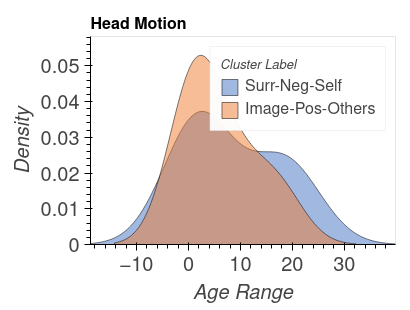

In [228]:
display.Image('./figures/S12_Clusters_age_KDEs.png')

In [231]:
age_distributions

0
Cluster Label    age (5-year bins)    
Surr-Neg-Self    45-50               1
                 40-45               2
                 30-35               3
                 25-30              20
                 20-25              17
Image-Pos-Others 40-45               1
                 35-40               1
                 30-35               2
                 25-30              17
                 20-25               9

In [229]:
ttest_rel(age_distributions.loc['Image-Pos-Others',:],age_distributions.loc['Surr-Neg-Self',:], alternative='two-sided')

TtestResult(statistic=array([-1.81150584]), pvalue=array([0.14429445]), df=array([4]))

In [230]:
wilcoxon(age_distributions.loc['Image-Pos-Others',:],age_distributions.loc['Surr-Neg-Self',:], alternative='two-sided', method='exact')

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=array([0.]), pvalue=array([0.06559969]))

In [136]:
age_distributions = age_distributions.reset_index()
age_distributions.columns = ['Scan Set','Age Range','# Scans']
age_distributions

,Scan Set,Age Range,# Scans
0,Surr-Neg-Self,45-50,1
1,Surr-Neg-Self,40-45,2
2,Surr-Neg-Self,30-35,3
3,Surr-Neg-Self,25-30,20
4,Surr-Neg-Self,20-25,17
5,Image-Pos-Others,40-45,1
6,Image-Pos-Others,35-40,1
7,Image-Pos-Others,30-35,2
8,Image-Pos-Others,25-30,17
9,Image-Pos-Others,20-25,9


In [137]:
f_age = age_distributions.hvplot(kind='bar',x='Scan Set',by='Age Range',c='gray',fontsize={'xticks':12,'yticks':15,'xlabel':12,'ylabel':15,'legend':12},width=400, height=200, xlabel='').opts(xrotation=90, toolbar=None)
pn.Row(f_age).save('./figures/S12_Clusters_Age.png')

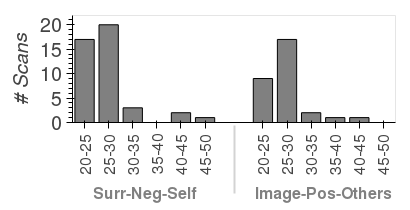

In [138]:
display.Image('./figures/S12_Clusters_Age.png')

In [118]:
W.reset_index().hvplot.scatter(x='Factor 1',y='Factor 2', aspect='square', c='Subject')

:Scatter   [Factor 1]   (Factor 2,Subject)